In [1]:
# relevant imports

import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torchvision.transforms as T
from torchvision.transforms import ToPILImage
import cv2
import torchvision.models as models
import time
import copy
import torch.optim as optim
from torch.utils.data import random_split
import pandas as pd


In [2]:
# define relevant parameters

n_epoch = 15
batch_size = 32
lr = 1e-3 # learning rate for adam optimiser. controls how quickly the model updates its weights during training (smaller is better for performance but takes much longer)
betas = (0.9, 0.999) # controls the exponential decay rates for the estimates of first and second moments of gradients (standard values)

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

# make results determinstic and repeatable
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
class DomainNet(Dataset):

    def __init__(self, folder_path, transforms, extensions=('jpg', 'jpeg', 'png')):

        map = {'backpack': 0, 'book': 1, 'car': 2, 'pizza': 3, 'sandwich': 4, 'snake': 5, 'sock': 6, 'tiger': 7, 'tree': 8, 'watermelon': 9}

        self.data = []
        self.labels = []

        for root, dirs, files in os.walk(folder_path):
          for f in files:
              if f.lower().endswith(extensions):
                label = os.path.basename(root)
                label = map[label]
                img = plt.imread(os.path.join(root, f))
                img = Image.fromarray(img)
                self.data.append(img)
                self.labels.append(label)

        self.labels = torch.tensor(self.labels, dtype=torch.long)
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index): # allows for indexing of the form obj[index] with Dataset Object
        img = self.data[index]
        if self.transforms is not None:
            img = self.transforms(img)
        return img, self.labels[index]

In [4]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # pretrained model expects this as input data
])

In [5]:
device

'cuda'

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
real_train_dataset = DomainNet(
                      folder_path= "/content/drive/MyDrive/Colab Notebooks/ENGN4528/Assignments/Assignment 2/data/real_train/", 
                      transforms= transforms
                        )

# Determine the split sizes
train_size = int(0.8 * len(real_train_dataset))
val_size = len(real_train_dataset) - train_size
print(train_size)
print(val_size)

# Split the dataset
real_train_dataset, real_val_dataset = random_split(real_train_dataset, [train_size, val_size])
print(len(real_train_dataset))
print(len(real_val_dataset))

# Create data loaders for the new datasets
real_train_loader = DataLoader(real_train_dataset, batch_size=batch_size, shuffle=True)
real_val_loader = DataLoader(real_val_dataset, batch_size=batch_size, shuffle=True)


3220
805
3220
805


In [ ]:
# real_test_dataset = DomainNet(
#                       folder_path= "/content/drive/MyDrive/Colab Notebooks/ENGN4528/Assignments/Assignment 2/data/real_test/", 
#                       transforms= transforms
#                         )

# real_test_loader = DataLoader(real_test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
sketch_train_dataset = DomainNet(
                      folder_path= "/content/drive/MyDrive/Colab Notebooks/ENGN4528/Assignments/Assignment 2/data/sketch_train/", 
                      transforms= transforms
                        )

# Determine the split sizes
train_size = int(0.8 * len(sketch_train_dataset))
val_size = len(sketch_train_dataset) - train_size
print(train_size)
print(val_size)

# Split the dataset
sketch_train_dataset, sketch_val_dataset = random_split(sketch_train_dataset, [train_size, val_size])
print(len(sketch_train_dataset))
print(len(sketch_val_dataset))

# Create data loaders for the new datasets
sketch_train_loader = DataLoader(sketch_train_dataset, batch_size=batch_size, shuffle=True)
sketch_val_loader = DataLoader(sketch_val_dataset, batch_size=batch_size, shuffle=True)



1568
393
1568
393


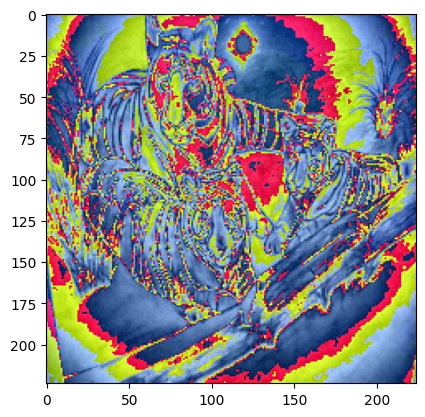

tensor(7)
tensor([8, 6, 2, 0, 5, 5, 9, 8, 7, 2, 3, 9, 2, 4, 5, 7, 9, 5, 3, 6, 6, 7, 8, 6,
        6, 6, 0, 7, 3, 3, 1, 7])


In [10]:
for i, (data, labels) in enumerate(sketch_train_loader):
  if i == 1:
    break
  else:
    pil = ToPILImage()
    plt.imshow(pil(data[31]))
    plt.show()
    print(labels[31])
    print(labels)

In [11]:
sketch_test_dataset = DomainNet(
                      folder_path= "/content/drive/MyDrive/Colab Notebooks/ENGN4528/Assignments/Assignment 2/data/sketch_test/", 
                      transforms= transforms
                        )

sketch_test_loader = DataLoader(sketch_test_dataset, batch_size=batch_size, shuffle=True)

In [12]:
print(len(sketch_test_dataset))

841


In [29]:
model = models.resnet34(pretrained=True)
input_features = model.fc.in_features
desired_features = 10
model.fc = nn.Linear(input_features, desired_features)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
def train(model, train_loader, val_loader, device, optimizer, n_epoch, train_losses, train_accuracies, val_losses, val_accuracies):
   
    model = model.to(device) # cast the model to the desired device
    starting_time = time.time() # record the starting time for the training process.
    loss_function = nn.CrossEntropyLoss() # define the loss function as cross-entropy loss.

    # keep track of the best validation accuracy and model state during training.
    best_val_acc = 0
    best_state = copy.deepcopy(model.state_dict())

    for epoch in range(n_epoch):

        # Training
        model.train() # set the model to train mode 

        # initialise metrics for tracking accuracy
        correct = 0 
        total = 0
        train_loss = 0

        # epoch_time = time.time()
        for i, (data, labels) in enumerate(train_loader):

            # to perform GPU computation, the data (originally stored on CPU) must be explicitly moved to GPU for computation
            # we need the model and the data to be on the same device.
            data, labels = data.to(device), labels.to(device)

            # zero the gradients of loss function before starting new iteration. 
            # calling backwards() causes gradients to be added on top of each other, so for each batch we want to zero the gradient 
            # so that we are training the model independently in each batch.
            optimizer.zero_grad()

            # use the model to predict the output for the current batch
            predicted_labels = model(data)

            # compare the predicted labels to the ground truth
            # smaller value for cross-entropy loss indicates better match between predicted and ground truth
            loss = loss_function(predicted_labels, labels)

            # predicted produces the predicted labels for the batch_size of samples as a tensor
            _, predicted = torch.max(predicted_labels.data, 1) 
            
            # perform backpropogation (calculates grad from outer layer to input layer)
            # calculate gradients of loss function with respect to each model parameter.
            loss.backward()

            # update model parameters based on calculated gradients. we update the model parameters by taking 
            # a step in the direction of the negative gradient.
            optimizer.step()

            # update counters
            train_loss += loss.item()
            total += labels.size(0) # adding batch_size to the total each time to represent the number of images we have processed
            correct += torch.sum(predicted == labels) # the number of correct predictions in each batch (max is 64)

        train_acc = correct / total # total correctly labelled samples out of all samples
        train_loss = train_loss / len(train_loader) # average training loss per batch

        train_losses.append(train_loss)
        train_accuracies.append(train_acc.item())

        print(f'Training complete for epoch {epoch}!')


        # Validation
        model.eval()
        correct = 0 
        total = 0
        val_loss = 0

        with torch.no_grad(): # temporarily disables gradient calculation. useful when evaluating and dont need to update weights. reduces memory consumption and speed
          for i, (data, labels) in enumerate(val_loader):
              data, labels = data.to(device), labels.to(device)

              # predict the output
              predicted_labels = model(data)

              # calculate the loss
              loss = loss_function(predicted_labels, labels)

              # update correct, total and val_loss
              val_loss += loss.item()
              total += labels.size(0) # adding batch_size to the total each time to represent the number of images we have processed

              _, predicted = torch.max(predicted_labels.data, 1)
              correct += torch.sum(predicted == labels)

          val_acc = correct / total
          val_loss = val_loss / len(val_loader)
          
          val_losses.append(val_loss)
          val_accuracies.append(val_acc.item())

          if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

        print(f'val correct for samples: {correct}/{total}')

        print(f'Epoch {epoch}/{n_epoch-1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        print(f'Best val Acc: {best_val_acc}')
        print('-' * 10)
        

    model.load_state_dict(best_state)


In [31]:
# Initialize lists to store the values for each epoch
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Call the train function and get the results
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)
train(model, sketch_train_loader, sketch_val_loader, device, optimizer, n_epoch, train_losses, train_accuracies, val_losses, val_accuracies)

Training complete for epoch 0!
val correct for samples: 239/393
Epoch 0/14, Train Loss: 1.4429, Train Acc: 0.5408, Val Loss: 1.1941, Val Acc: 0.6081
Training complete in 0m 16s
Best val Acc: 0.608142
----------
Training complete for epoch 1!
val correct for samples: 175/393
Epoch 1/14, Train Loss: 0.8838, Train Acc: 0.7270, Val Loss: 1.9000, Val Acc: 0.4453
Training complete in 0m 31s
Best val Acc: 0.608142
----------
Training complete for epoch 2!
val correct for samples: 242/393
Epoch 2/14, Train Loss: 0.6265, Train Acc: 0.7844, Val Loss: 1.3371, Val Acc: 0.6158
Training complete in 0m 46s
Best val Acc: 0.615776
----------
Training complete for epoch 3!
val correct for samples: 266/393
Epoch 3/14, Train Loss: 0.5101, Train Acc: 0.8284, Val Loss: 1.0797, Val Acc: 0.6768
Training complete in 1m 2s
Best val Acc: 0.676845
----------
Training complete for epoch 4!
val correct for samples: 216/393
Epoch 4/14, Train Loss: 0.4246, Train Acc: 0.8673, Val Loss: 1.7892, Val Acc: 0.5496
Training

In [12]:
def save_results(train_losses, train_accuracies, val_losses, val_accuracies):
  # Save the results to a CSV file
  results_df = pd.DataFrame({"train_loss": train_losses, "train_accuracy": train_accuracies, "val_loss": val_losses, "val_accuracy": val_accuracies})
  results_df.to_csv("results.csv", index=False)

  # Plot the training and validation accuracy
  plt.plot(train_accuracies, label="Training Accuracy")
  plt.plot(val_accuracies, label="Validation Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title("Training and Validation Accuracy")
  plt.legend()
  plt.show()

  # Plot the training and validation loss
  plt.plot(train_losses, label="Training Loss")
  plt.plot(val_losses, label="Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training and Validation Loss")
  plt.legend()
  plt.show()

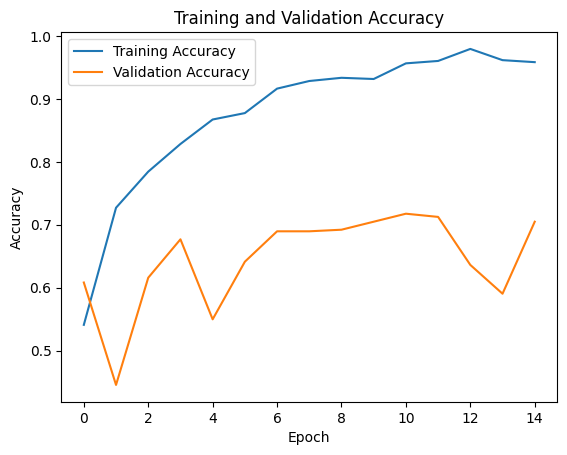

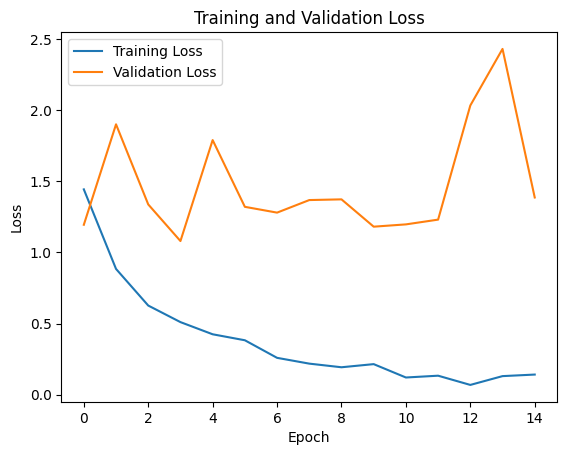

In [32]:
save_results(train_losses, train_accuracies, val_losses, val_accuracies)

In [33]:
from google.colab import files
files.download('results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
# Save the model parameters
model_path = "model_weights_2.pt"
torch.save(model.state_dict(), model_path)

In [26]:
def test(model, test_loader, device):

    loss_function = nn.CrossEntropyLoss() # define the loss as cross-entropy loss

    # Testing
    model.eval() # set the model to evaluation mode

    # initialise counters
    correct = 0 
    total = 0
    test_loss = 0

    with torch.no_grad():
      for data, labels in test_loader:
          data, labels = data.to(device), labels.to(device)

          # predict the output
          predicted_labels = model(data)

          # calculate the loss
          loss = loss_function(predicted_labels, labels)

          # update correct, total and test_loss
          test_loss += loss.item()
          total += labels.size(0) # adds 
          
          _, predicted = torch.max(predicted_labels.data, 1)
          correct += torch.sum(predicted == labels)


      test_acc = correct / total
      test_loss = test_loss / len(test_loader)
      
      print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
      return test_acc, test_loss

In [37]:
model_state_dict = torch.load(model_path)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [38]:
test_acc, test_loss = test(model, sketch_test_loader, device)

Test Loss: 1.1698, Test Acc: 0.7039


## Q2c: Train (Real), Test (Sketch)

In [40]:
model = models.resnet34(pretrained=True)
input_features = model.fc.in_features
desired_features = 10
model.fc = nn.Linear(input_features, desired_features)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
# Initialize lists to store the values for each epoch
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Call the train function and get the results
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)
train(model, real_train_loader, real_val_loader, device, optimizer, n_epoch, train_losses, train_accuracies, val_losses, val_accuracies)

Training complete for epoch 0!
val correct for samples: 593/805
Epoch 0/14, Train Loss: 0.8339, Train Acc: 0.7516, Val Loss: 0.8494, Val Acc: 0.7366
Training complete in 0m 31s
Best val Acc: 0.736646
----------
Training complete for epoch 1!
val correct for samples: 697/805
Epoch 1/14, Train Loss: 0.5062, Train Acc: 0.8370, Val Loss: 0.4613, Val Acc: 0.8658
Training complete in 1m 5s
Best val Acc: 0.865838
----------
Training complete for epoch 2!
val correct for samples: 651/805
Epoch 2/14, Train Loss: 0.3584, Train Acc: 0.8922, Val Loss: 0.7064, Val Acc: 0.8087
Training complete in 1m 38s
Best val Acc: 0.865838
----------
Training complete for epoch 3!
val correct for samples: 648/805
Epoch 3/14, Train Loss: 0.3132, Train Acc: 0.8994, Val Loss: 0.7165, Val Acc: 0.8050
Training complete in 2m 13s
Best val Acc: 0.865838
----------
Training complete for epoch 4!
val correct for samples: 651/805
Epoch 4/14, Train Loss: 0.2435, Train Acc: 0.9236, Val Loss: 0.7182, Val Acc: 0.8087
Training

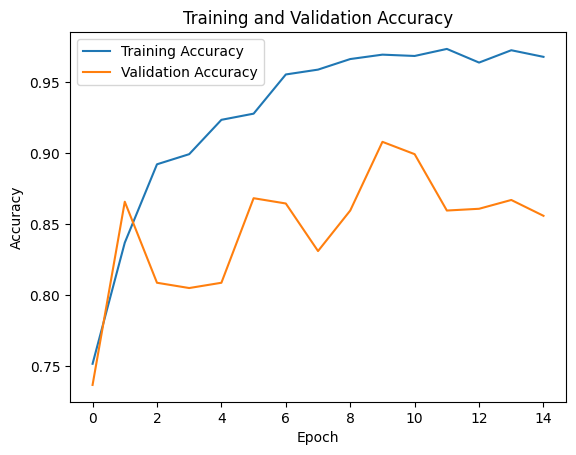

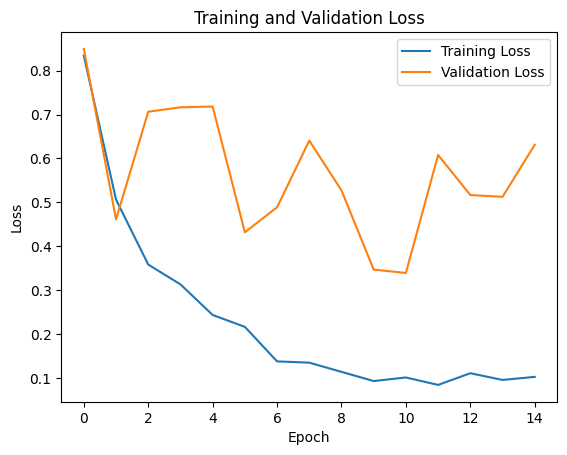

In [44]:
save_results(train_losses, train_accuracies, val_losses, val_accuracies)

In [45]:
from google.colab import files
files.download('results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
# Save the model parameters
model_path = "model_weights_3.pt"
torch.save(model.state_dict(), model_path)

In [47]:
test_acc, test_loss = test(model, sketch_test_loader, device)

Test Loss: 2.9381, Test Acc: 0.4542


## Q3: Mean Discrepency Domain Adaptation

In [41]:
# Extract features of ResNet-34 (second last layer) and output at final layer
class ResNet34FeatureExtractor(nn.Module):
    def __init__(self, num_classes):
        super(ResNet34FeatureExtractor, self).__init__()
        self.resnet34 = models.resnet34(pretrained=True) # load in the resnet34 model 
        resnet34_layers = list(self.resnet34.children()) # Layers of ResNet-34 as a list
        resnet34_layers = resnet34_layers[:-1] # Remove last layer (fc) from the list
        self.resnet34 = nn.Sequential(*resnet34_layers) # Unpacked remaining layers --> sequential model
        self.fc = nn.Linear(512, num_classes) # Add new fully connected layer

    def forward(self, x):
        features = self.resnet34(x) # Get features from modified ResNet-34 model
        features = features.view(features.size(0), -1) # Flatten features to shape (batch_size, num_features)
        output = self.fc(features) # Pass features through new fc layer to get outputs for 10 classes
        return output, features 

In [42]:
model = ResNet34FeatureExtractor(num_classes=10) # Replace the existing model definition

In [44]:
def domain_adaptation_loss(source_features, target_features, predicted_labels, labels, mean_discrepancy_weight):
    loss = nn.CrossEntropyLoss() # Define the loss for classification
    classification_loss = loss(predicted_labels, labels) # Calculate the classification loss using predicted labels and ground truth labels

    source_mean = torch.mean(source_features, dim=0) # Calculate mean of source features along batch dimension
    target_mean = torch.mean(target_features, dim=0) # Calculate mean of target features along batch dimension
    mean_discrepancy_loss = torch.norm(source_mean - target_mean, p=2) ** 2 # Calculate squared Euclidean distance between source and target feature means

    total_loss = classification_loss + mean_discrepancy_weight * mean_discrepancy_loss # Combine the classification loss and mean discrepancy loss using the provided weight

    return total_loss


In [53]:
# Modified train method to integrate MMD loss
def train_mmd(model, source_train_loader, mean_discrepancy_weight, target_train_loader, device, optimizer, n_epoch, train_losses, train_accuracies, val_losses, val_accuracies):
   
    model = model.to(device) # Move the model to the desired device (CPU or GPU)
    starting_time = time.time() # Record the starting time for the training process
    loss_function = nn.CrossEntropyLoss() # Define the loss function as cross-entropy loss

    new_state = copy.deepcopy(model.state_dict()) # Save a copy of the current model state

    for epoch in range(n_epoch):

        # Training
        model.train() # Set the model to train mode

        # Initialize metrics for tracking accuracy
        correct = 0
        total = 0
        train_loss = 0

        # Iterate over batches of source and target data
        for (source_data, source_labels), (target_data, _) in zip(source_train_loader, target_train_loader):

            # Move the data to the same device as the model for computation
            source_data, source_labels = source_data.to(device), source_labels.to(device)
            target_data = target_data.to(device)

            # Zero the gradients of the optimizer before starting a new iteration
            optimizer.zero_grad()

            # Pass the source and target data through the model
            source_output, source_features = model(source_data)
            target_output, target_features = model(target_data)

            # Calculate the domain adaptation loss
            loss = domain_adaptation_loss(source_features, target_features, source_output, source_labels, mean_discrepancy_weight)

            # Get the predicted labels for the source data
            _, predicted = torch.max(source_output.data, 1)

            # Perform backpropagation to update model parameters
            loss.backward()
            optimizer.step()

            # Update counters
            train_loss += loss.item()
            total += source_labels.size(0) # Add the batch size to the total count of processed images
            correct += torch.sum(predicted == source_labels) # Count the number of correct predictions in each batch

        # Calculate the training accuracy and loss for this epoch
        train_acc = correct / total
        train_loss = train_loss / (len(source_train_loader) + len(target_train_loader))

        # Update the lists of training losses and accuracies
        train_losses.append(train_loss)
        train_accuracies.append(train_acc.item())

        # Print the training results for this epoch
        print(f'Training complete for epoch {epoch}!')
        print(f'Epoch {epoch}/{n_epoch-1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print('-' * 10)
        
        # Update the saved model state
        new_state = copy.deepcopy(model.state_dict())

    print('TRAINING COMPLETE')
    model.load_state_dict(new_state) # Load the best model state

In [54]:
# Modified test function to include MMD domain adaptation
def test_mmd(model, test_loader, device):

    loss_function = nn.CrossEntropyLoss() # define the loss as cross-entropy loss

    model.eval() # set the model to evaluation mode

    # initialise counters
    correct = 0 
    total = 0
    test_loss = 0

    with torch.no_grad(): # don't compute gradients during test to save memory
      for data, labels in test_loader:
          data, labels = data.to(device), labels.to(device)

          # predict the output
          output, _ = model(data)

          # calculate the loss
          loss = loss_function(output, labels)

          # update correct, total and test_loss
          test_loss += loss.item()
          total += labels.size(0) 
          
          _, predicted = torch.max(output.data, 1) # get the predicted label for each image
          correct += torch.sum(predicted == labels) # count the number of correct predictions

      test_acc = correct / total # compute test accuracy
      test_loss = test_loss / len(test_loader) # compute test loss per batch
      
      print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
      return test_acc, test_loss

In [47]:
# Initialize lists to store the values for each epoch
train_losses = []
train_accuracies = []

# Call the train function and get the results
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)
mean_discrepancy_weight = 0.01 # Add a weight for the mean discrepancy loss
train_mmd(model, real_train_loader, mean_discrepancy_weight, sketch_train_loader, device, optimizer, n_epoch, train_losses, train_accuracies, val_losses, val_accuracies)

Training complete for epoch 0!
Epoch 0/14, Train Loss: 0.3452, Train Acc: 0.6958
----------
Training complete for epoch 1!
Epoch 1/14, Train Loss: 0.2037, Train Acc: 0.8042
----------
Training complete for epoch 2!
Epoch 2/14, Train Loss: 0.1776, Train Acc: 0.8355
----------
Training complete for epoch 3!
Epoch 3/14, Train Loss: 0.1525, Train Acc: 0.8591
----------
Training complete for epoch 4!
Epoch 4/14, Train Loss: 0.1383, Train Acc: 0.8635
----------
Training complete for epoch 5!
Epoch 5/14, Train Loss: 0.1248, Train Acc: 0.8929
----------
Training complete for epoch 6!
Epoch 6/14, Train Loss: 0.0978, Train Acc: 0.9088
----------
Training complete for epoch 7!
Epoch 7/14, Train Loss: 0.0880, Train Acc: 0.9171
----------
Training complete for epoch 8!
Epoch 8/14, Train Loss: 0.0756, Train Acc: 0.9324
----------
Training complete for epoch 9!
Epoch 9/14, Train Loss: 0.0781, Train Acc: 0.9254
----------
Training complete for epoch 10!
Epoch 10/14, Train Loss: 0.0733, Train Acc: 0.92

In [56]:
def plot_results_mmd(train_losses, train_accuracies):
  
  # Plot the training and validation accuracy
  plt.plot(train_accuracies, label="Training Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title("Training Accuracy")
  plt.show()

  # Plot the training and validation loss
  plt.plot(train_losses, label="Training Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training Loss")
  plt.show()

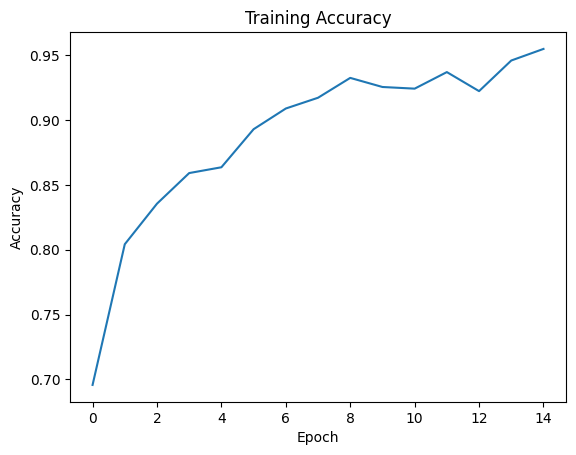

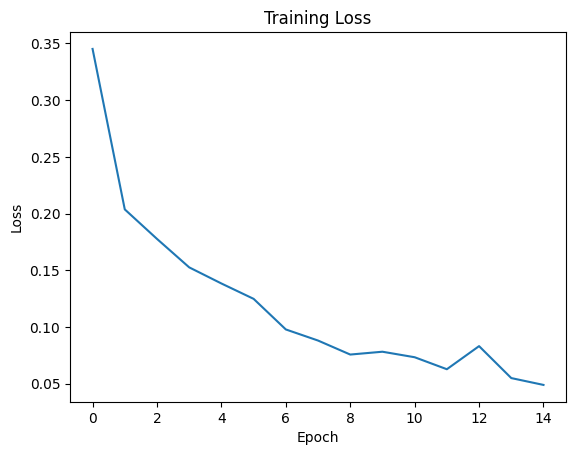

In [58]:
plot_results_mmd(train_losses, train_accuracies)

In [49]:
from google.colab import files
files.download('results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
# Save the model parameters
model_path = "model_weights_5.pt"
torch.save(model.state_dict(), model_path)

In [51]:
test_acc, test_loss = test_mmd(model, sketch_test_loader, device)

Test Loss: 2.8879, Test Acc: 0.4328
